In [36]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import os
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image, UnidentifiedImageError
from torchvision import models



In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!nvidia-smi

Fri Jan 10 12:42:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              29W /  70W |   2171MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
dataset_folder_path = '/content/drive/MyDrive/Datasets'
sports_dataset_folder_path = os.path.join(dataset_folder_path,'sports100')
os.makedirs(sports_dataset_folder_path,exist_ok=True)


# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")


for file in os.listdir(path):
  shutil.move(os.path.join(path,file),os.path.join(sports_dataset_folder_path,file))

print(f'dataset downloaded to this path{sports_dataset_folder_path}')

dataset downloaded to this path/content/drive/MyDrive/Datasets/sports100


In [41]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/sports100/sports.csv')

In [42]:
df.head()

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


In [44]:
df.describe()

,class id
count,14493.000000
mean,49.206375
std,28.357108
min,0.000000
25%,25.000000
50%,49.000000
75%,73.000000
max,99.000000


In [45]:
#split into train and valid and test set
train_df = df[df['data set']=='train']
val_df = df[df['data set']=='valid']
test_df = df[df['data set']=='test']

In [46]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

13493
500
500


In [47]:

class SportsDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        # Create a mapping from class labels to integers
        self.class_to_idx = {cls: idx for idx, cls in enumerate(df['labels'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df['filepaths'].iloc[idx])
        try:
            # Try to load the image
            image = Image.open(img_path).convert('RGB')
        except (UnidentifiedImageError, IOError, OSError) as e:
            # If the image is invalid, return a placeholder image and label
            print(f"Error loading image: {img_path} (Error: {e})")
            image = Image.new('RGB', (224, 224), (0, 0, 0))  # Black placeholder image
            label = 0  # Default label
        else:
            # If the image is valid, get the label
            label = self.df['labels'].iloc[idx]
            label = self.class_to_idx[label]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [48]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

# Base directory for images
train_img_dir = '/content/drive/MyDrive/Datasets/sports100'
test_img_dir = '/content/drive/MyDrive/Datasets/sports100'
val_img_dir = '/content/drive/MyDrive/Datasets/sports100'

# Create datasets
train_dataset = SportsDataset(train_df, img_dir=train_img_dir, transform=train_transform)
val_dataset = SportsDataset(val_df, img_dir=val_img_dir, transform=val_transform)
test_dataset = SportsDataset(test_df, img_dir=test_img_dir, transform=test_transform)

# Debugging prints
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train dataset size: 13493
Validation dataset size: 500
Test dataset size: 500
Class to index mapping: {'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'horseshoe pitching': 44, 'hurdles': 45, 'hydroplane racing': 46, 'ice climbing': 47, '

In [49]:
# Test the train loader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels: tensor([16, 27, 30, 18, 16, 96, 16, 86, 98, 68, 31, 92, 95, 57, 35, 42, 21, 58,
        41, 28, 72, 35, 83, 28, 73, 43, 18,  4, 12, 75, 92, 41, 76,  9, 88, 68,
        46, 33, 40, 69, 89, 61, 68,  6, 86, 89, 44, 10, 24, 10,  1,  8, 92,  7,
        14, 73, 76, 32, 76, 17, 75, 16, 64, 64])


In [50]:
print(len(train_loader))
print(len(val_loader))

211
8


#train and test function

In [51]:
# Initialize variables to save the best model
best_val_loss = float('inf')  # Start with infinity
best_model_weights = None

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy



In [52]:
def test(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")



In [53]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)


In [54]:
# Plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


#Summary of Models (Sorted by Size)
Model Name	Parameters (Approx.)	Use Case

SqueezeNet 1.0	~1.25M	Mobile/Embedded Devices

ShuffleNet V2 (x1.0)	~2.3M	Mobile/Embedded Devices

MobileNet V2	~3.5M	Mobile/Embedded Devices

MNASNet 1.0	~4.4M	Mobile/Embedded Devices

EfficientNet B0	~5.3M	General-Purpose

DenseNet121	~8M	General-Purpose

ResNet18	~11.7M	General-Purpose

VGG11	~132M	General-Purpose

EfficientNet B7	~66M	High Accuracy

DenseNet201	~20M	High Accuracy

ResNet50	~25.6M	High Accuracy

Inception V3	~27M	High Accuracy

ResNet101	~44.5M	High Accuracy

ResNet152	~60.2M	High Accuracy

VGG19	~144M	High Accuracy

ViT B/16	~86M	State-of-the-Art

RegNet Y 32GF	~145M	State-of-the-Art

ViT L/16	~307M	State-of-the-Art

#Resnet18

In [55]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final layer for 100 classes
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)
num_epoch = 10

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [57]:
# Training loop with early stopping and saving the best model
for epoch in range(num_epoch):
    # Train for one epoch
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate for one epoch
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print('-' * 100)
    print(f'Epoch [{epoch + 1}/{num_epoch}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# After training, save the best model weights to a file
torch.save(best_model_weights, 'best_model_weights.pth')
print("Best model weights saved to 'best_model_weights.pth'.")

Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
----------------------------------------------------------------------------------------------------
Epoch [1/10], Train Loss: 1.6596, Train Accuracy: 57.14%, Val Loss: 1.3003, Val Accuracy: 63.00%
Best model weights saved.
Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
----------------------------------------------------------------------------------------------------
Epoch [2/10], Train Loss: 0.7698, Train Accuracy: 77.91%, Val Loss: 0.7893, Val Accuracy: 78.00%
Best model weights saved.
Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train

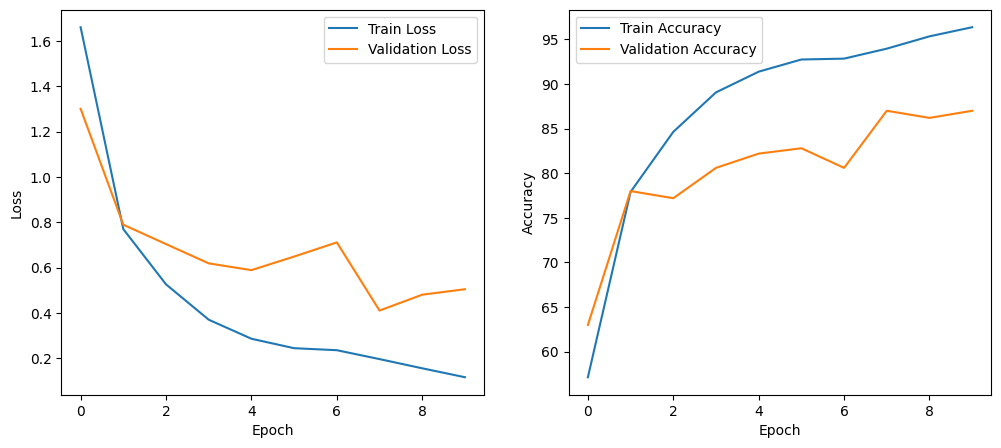

In [58]:

# Call this function at the end of training
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [59]:
test(model, test_loader, device)

Test Accuracy: 0.8940


#resnet50

In [61]:

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final layer for 100 classes
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)
num_epoch = 10

# Clear metric lists before training a new model
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

In [62]:
# Training loop with early stopping and saving the best model
for epoch in range(num_epoch):
    # Train for one epoch
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate for one epoch
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print('-' * 100)
    print(f'Epoch [{epoch + 1}/{num_epoch}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# After training, save the best model weights to a file
torch.save(best_model_weights, 'best_model_resnet50_weights.pth')
print("Best model weights saved to 'best_model_weights.pth'.")

Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
----------------------------------------------------------------------------------------------------
Epoch [1/10], Train Loss: 2.3611, Train Accuracy: 38.72%, Val Loss: 2.0264, Val Accuracy: 50.00%
Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
----------------------------------------------------------------------------------------------------
Epoch [2/10], Train Loss: 1.2949, Train Accuracy: 62.83%, Val Loss: 1.1171, Val Accuracy: 67.00%
Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
-------------------------------

#VGG19 model

In [63]:

# Load pretrained VGG19
model = models.vgg19(pretrained=True)

# Modify the final layer for 100 classes
num_classes = 100
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)

# Number of epochs
num_epoch = 10

# Clear metric lists before training a new model
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 132MB/s]


In [64]:
# Training loop with early stopping and saving the best model
for epoch in range(num_epoch):
    # Train for one epoch
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate for one epoch
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print('-' * 100)
    print(f'Epoch [{epoch + 1}/{num_epoch}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# After training, save the best model weights to a file
torch.save(best_model_weights, 'best_model_resnet50_weights.pth')
print("Best model weights saved to 'best_model_weights.pth'.")

Error loading image: /content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk (Error: cannot identify image file '/content/drive/MyDrive/Datasets/sports100/train/high jump/159.lnk')
----------------------------------------------------------------------------------------------------
Epoch [1/10], Train Loss: 4.6416, Train Accuracy: 1.34%, Val Loss: 4.6012, Val Accuracy: 0.80%
Early stopping triggered
Early stopping triggered at epoch 1
Best model weights saved to 'best_model_weights.pth'.


#YOLOv8m model

In [65]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 52.0 MB/s eta 0:00:00


In [66]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 classification model (medium size)
model = YOLO('yolov8m-cls.pt')  # 'm' stands for medium size

# Train the model on your dataset
results = model.train(
    data='/content/drive/MyDrive/Datasets/sports100',  # Path to your dataset
    epochs=10,                # Number of epochs
    imgsz=224,                # Image size
    batch=32,                 # Batch size
    name='yolov8m_cls_sports100',  # Name of the training run
    project='classification', # Project name
    optimizer='Adam',         # Optimizer
    lr0=0.001,               # Initial learning rate
    patience=3,              # Early stopping patience
    device='0'               # Use GPU (set to 'cpu' if no GPU is available)
)

# Evaluate the model on the validation set
metrics = model.val()

# Export the model to ONNX format (optional)
model.export(format='onnx')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 32.7M/32.7M [00:01<00:00, 31.1MB/s]

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/drive/MyDrive/Datasets/sports100, epochs=10, time=None, patience=3, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=classification, name=yolov8m_cls_sports100, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: /content/drive/MyDrive/Datasets/sports100/train... found 13492 images in 100 classes ✅ 
val: None...
test: /content/drive/MyDrive/Datasets/sports100/test... found 500 images in 100 classes ✅ 
Overriding model.yaml nc=1000 with nc=100

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv    

100%|██████████| 5.35M/5.35M [00:00<00:00, 251MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Datasets/sports100/train... 13492 images, 0 corrupt: 100%|██████████| 13492/13492 [01:07<00:00, 200.64it/s]


train: New cache created: /content/drive/MyDrive/Datasets/sports100/train.cache


val: Scanning /content/drive/MyDrive/Datasets/sports100/test... 500 images, 0 corrupt: 100%|██████████| 500/500 [00:04<00:00, 105.74it/s]


val: New cache created: /content/drive/MyDrive/Datasets/sports100/test.cache
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to classification/yolov8m_cls_sports100
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/10      13.9G       4.69         32        224:   0%|          | 2/422 [00:01<04:25,  1.58it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Determi

       1/10      13.9G      4.661         32        224:   4%|▍         | 16/422 [00:05<01:50,  3.67it/s]
100%|██████████| 755k/755k [00:00<00:00, 130MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

                   all      0.624      0.906



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all       0.82      0.986



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

                   all      0.864      0.982



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]

                   all      0.904       0.99



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]

                   all      0.926      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all      0.934      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all      0.954      0.996



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/422 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/10       9.2G     0.1231         20        224: 100%|██████████| 422/422 [02:25<00:00,  2.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  2.71

                   all       0.97      0.998



10 epochs completed in 0.423 hours.
Optimizer stripped from classification/yolov8m_cls_sports100/weights/last.pt, 31.9MB
Optimizer stripped from classification/yolov8m_cls_sports100/weights/best.pt, 31.9MB

Validating classification/yolov8m_cls_sports100/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLOv8m-cls summary (fused): 103 layers, 15,890,756 parameters, 0 gradients, 41.7 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Datasets/sports100/train... found 13492 images in 100 classes ✅ 
val: None...
test: /content/drive/MyDrive/Datasets/sports100/test... found 500 images in 100 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]


                   all       0.97      0.998
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to classification/yolov8m_cls_sports100
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLOv8m-cls summary (fused): 103 layers, 15,890,756 parameters, 0 gradients, 41.7 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Datasets/sports100/train... found 13492 images in 100 classes ✅ 
val: None...
test: /content/drive/MyDrive/Datasets/sports100/test... found 500 images in 100 classes ✅ 


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [71]:
# Load the trained model
model = YOLO('classification/yolov8m_cls_sports100/weights/best.pt')

# Predict on an image
results = model.predict('/content/drive/MyDrive/Datasets/sports100/test/air hockey/1.jpg')

# Get class names
class_names = model.names

# Print top-1 prediction
top1_index = results[0].probs.top1
top1_conf = results[0].probs.top1conf
print(f"Top-1 Prediction: {class_names[top1_index]} (Confidence: {top1_conf:.4f})")

# Print top-5 predictions
top5_indices = results[0].probs.top5
top5_confs = results[0].probs.top5conf
print("Top-5 Predictions:")
for i, (index, conf) in enumerate(zip(top5_indices, top5_confs)):
    print(f"{i + 1}: {class_names[index]} (Confidence: {conf:.4f})")


image 1/1 /content/drive/MyDrive/Datasets/sports100/test/air hockey/1.jpg: 224x224 air hockey 1.00, billiards 0.00, gaga 0.00, table tennis 0.00, fencing 0.00, 7.1ms
Speed: 3.5ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Top-1 Prediction: air hockey (Confidence: 1.0000)
Top-5 Predictions:
1: air hockey (Confidence: 1.0000)
2: billiards (Confidence: 0.0000)
3: gaga (Confidence: 0.0000)
4: table tennis (Confidence: 0.0000)
5: fencing (Confidence: 0.0000)


In [75]:
!mv /content/drive/MyDrive/Datasets/sports100/valid /content/drive/MyDrive/Datasets/sports100/val

In [76]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('classification/yolov8m_cls_sports100/weights/best.pt')

# Validate the model on the test dataset
metrics = model.val(data='/content/drive/MyDrive/Datasets/sports100')

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,890,756 parameters, 0 gradients, 41.7 GFLOPs
train: /content/drive/MyDrive/Datasets/sports100/train... found 13492 images in 100 classes ✅ 
val: /content/drive/MyDrive/Datasets/sports100/val... found 500 images in 100 classes ✅ 
test: /content/drive/MyDrive/Datasets/sports100/test... found 500 images in 100 classes ✅ 


val: Scanning /content/drive/MyDrive/Datasets/sports100/val... 500 images, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 172.99it/s]


val: New cache created: /content/drive/MyDrive/Datasets/sports100/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


                   all      0.966      0.998
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val4
